<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Deep_Learning/Example_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [ ]:
print(len(train_labels))
print(len(test_labels))

60000
10000


In [ ]:
model = keras.Sequential([layers.Dense(512, activation="relu"), 
                          layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32")/255

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 10ms/step - loss: 0.2591 - accuracy: 0.9232
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1041 - accuracy: 0.9689
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0683 - accuracy: 0.9793
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0498 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0381 - accuracy: 0.9884


In [ ]:
def display_img(img, target, ax):
  img = img.reshape((28,28))
  ax.imshow(img, cmap='gray')
  ax.set_title(f'Digit: {str(target)}')
  ax.grid(False)

[7.1687829e-08 3.7164154e-11 7.4916185e-05 1.3959939e-04 6.7845702e-13
 1.8369743e-08 8.0372830e-15 9.9977499e-01 7.3273907e-07 9.7309294e-06]
Predicted label: 7
Expected label: 7


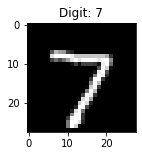

In [ ]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
print(predictions[0])
print(f"Predicted label: {predictions[0].argmax()}")
print(f"Expected label: {test_labels[0]}")

fig, ax = plt.subplots(1,1,figsize=(2,2))
display_img(test_digits[0], test_labels[0], ax)

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0728 - accuracy: 0.9785
Test accuracy: 0.979


In [ ]:
# Reimplementing the above process from sratch
class NaiveDense:
  def __init__(self, input_size, output_size, activation):
    self.activation = activation
    w_shape = (input_size, output_size)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.W = tf.Variable(w_initial_value)
    b_shape = (output_size,)
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)
  
  def __call__(self, inputs):
    return self.activation(tf.matmul(inputs, self.W) + self.b)

  @property
  def weights(self):
    return [self.W, self.b]

class NaiveSequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [ ]:
# Using the naive implementation of neural network
model = NaiveSequential([
     NaiveDense(input_size=28*28, output_size=512, activation=tf.nn.relu),
     NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [ ]:
# A batch generator
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):
    assert len(images) == len(labels)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil((len(images)/batch_size))

  def next(self):
    images = self.images[self.index : self.index + self.batch_size]
    labels = self.labels[self.index : self.index + self.batch_size]
    self.index += self.batch_size
    return images, labels

In [ ]:
# Naive implementation of the training process
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    predictions = model(images_batch)
    per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
        labels_batch, predictions)
    average_loss = tf.reduce_mean(per_sample_losses)
  gradients = tape.gradient(average_loss, model.weights)
  update_weights(gradients, model.weights)
  return average_loss

def update_weights(gradients, weights, learning_rate=1e-3):
  for g, w in zip(gradients, weights):
    w.assign_sub(g*learning_rate)

In [ ]:
# The full training loop
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f"Epoch {epoch_counter}")
    batch_generator = BatchGenerator(images, labels)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f"loss at batch {batch_counter}: {loss:.2f}")

In [ ]:
# Running the training
fit(model, train_images, train_labels, epochs=10, batch_size=128)
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

Epoch 0
loss at batch 0: 0.60
loss at batch 100: 0.60
loss at batch 200: 0.51
loss at batch 300: 0.58
loss at batch 400: 0.66
Epoch 1
loss at batch 0: 0.55
loss at batch 100: 0.57
loss at batch 200: 0.49
loss at batch 300: 0.56
loss at batch 400: 0.64
Epoch 2
loss at batch 0: 0.53
loss at batch 100: 0.54
loss at batch 200: 0.47
loss at batch 300: 0.54
loss at batch 400: 0.62
Epoch 3
loss at batch 0: 0.51
loss at batch 100: 0.52
loss at batch 200: 0.45
loss at batch 300: 0.52
loss at batch 400: 0.61
Epoch 4
loss at batch 0: 0.49
loss at batch 100: 0.50
loss at batch 200: 0.43
loss at batch 300: 0.51
loss at batch 400: 0.60
Epoch 5
loss at batch 0: 0.48
loss at batch 100: 0.49
loss at batch 200: 0.42
loss at batch 300: 0.49
loss at batch 400: 0.58
Epoch 6
loss at batch 0: 0.46
loss at batch 100: 0.47
loss at batch 200: 0.41
loss at batch 300: 0.48
loss at batch 400: 0.57
Epoch 7
loss at batch 0: 0.45
loss at batch 100: 0.46
loss at batch 200: 0.39
loss at batch 300: 0.47
loss at batch 40

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3,1)))
print(v)
v.assign(tf.ones((3,1)))
v[0,0].assign(3.)
v.assign_add(tf.ones((3,1)))

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.944124 ],
       [-0.5112382],
       [-0.617996 ]], dtype=float32)>


<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [ ]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [ ]:
time = tf.Variable(1.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9*time**2
  speed = inner_tape.gradient(position, time)
  print(f"speed (1-st derivative): {speed:.2f}")
acceleration = outer_tape.gradient(speed, time)
print(f"acceleartion (2nd derivative): {acceleration:.2f}")

speed (1-st derivative): 9.80
acceleartion (2nd derivative): 9.80


In [ ]:
# A linear classifier in pure TensorFlow
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1,0.5],[0.5,1]],
    size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3,0],
    cov=[[1,0.5],[0.5,1]],
    size=num_samples_per_class
)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

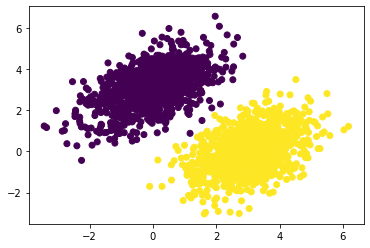

In [ ]:
plt.scatter(inputs[:,0], inputs[:,1], c=targets[:,0])
plt.show()

In [ ]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

def model(inputs):
  return tf.matmul(inputs, W) + b

def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

def training_step(inputs, targets, learning_rate=0.1):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(predictions, targets)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W*learning_rate)
  b.assign_sub(grad_loss_wrt_b*learning_rate)
  return loss

for step in range(40):
  loss = training_step(inputs, targets)
  print(f"Loss at step {step+1}: {loss:.4f}")

Loss at step 1: 1.8783
Loss at step 2: 0.3283
Loss at step 3: 0.1378
Loss at step 4: 0.1054
Loss at step 5: 0.0955
Loss at step 6: 0.0892
Loss at step 7: 0.0838
Loss at step 8: 0.0789
Loss at step 9: 0.0744
Loss at step 10: 0.0703
Loss at step 11: 0.0665
Loss at step 12: 0.0630
Loss at step 13: 0.0598
Loss at step 14: 0.0569
Loss at step 15: 0.0542
Loss at step 16: 0.0517
Loss at step 17: 0.0495
Loss at step 18: 0.0474
Loss at step 19: 0.0455
Loss at step 20: 0.0437
Loss at step 21: 0.0421
Loss at step 22: 0.0407
Loss at step 23: 0.0393
Loss at step 24: 0.0381
Loss at step 25: 0.0369
Loss at step 26: 0.0359
Loss at step 27: 0.0349
Loss at step 28: 0.0340
Loss at step 29: 0.0332
Loss at step 30: 0.0325
Loss at step 31: 0.0318
Loss at step 32: 0.0312
Loss at step 33: 0.0306
Loss at step 34: 0.0301
Loss at step 35: 0.0296
Loss at step 36: 0.0291
Loss at step 37: 0.0287
Loss at step 38: 0.0284
Loss at step 39: 0.0280
Loss at step 40: 0.0277


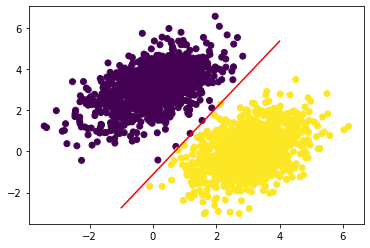

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:,0], inputs[:,1], c=predictions[:,0] > 0.5)
x = np.linspace(-1, 4, 100)
y = (-W[0]/W[1])*x + (0.5-b)/W[1]
plt.plot(x, y, "-r")
plt.show()

In [ ]:
# Naive neural network implemented using Keras
class SimpleDense(keras.layers.Layer):
  def __init__(self, units, activation=None):
    super().units = units
    self.activation = activation

  def build(self, input_shape):
    input_dim = input_shape[-1]
    self.W = self.add_weight(shape=(input_dim, self.units),
                             initializer="random_normal")
    self.b = self.add_weight(shape=(self.units,),
                             initializer="zeros")
    
  def call(self, inputs):
    y = tf.matmul(inputs, self.W) + self.b
    if self.activation is not None:
      y = self.activation(y)
    return y

In [ ]:
np.random.permutation(10)

array([5, 7, 0, 6, 8, 4, 1, 3, 2, 9])

In [ ]:
model = keras.Sequential(
    [layers.Dense(64, activation="relu"),
     layers.Dense(10, activation="softmax")]
)

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [ ]:
model.build(input_shape=(None, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [2]:
# A multi-input, multi-output functional model
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])

In [3]:
# Training a model by providing lists of input and target arrays
num_samples = 1280

# dummy input data
title_data = np.random.randint(0,2,size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0,2,size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0,2,size=(num_samples, num_tags))

# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0,2,size=(num_samples, num_departments))

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"],["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 1s 13ms/step - loss: 14.4094 - priority_loss: 0.3366 - department_loss: 14.0728 - priority_mean_absolute_error: 0.4999 - department_accuracy: 0.0539


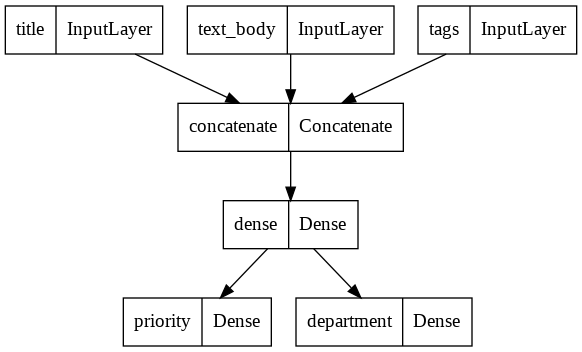

In [4]:
keras.utils.plot_model(model, "ticket_classifier.png")

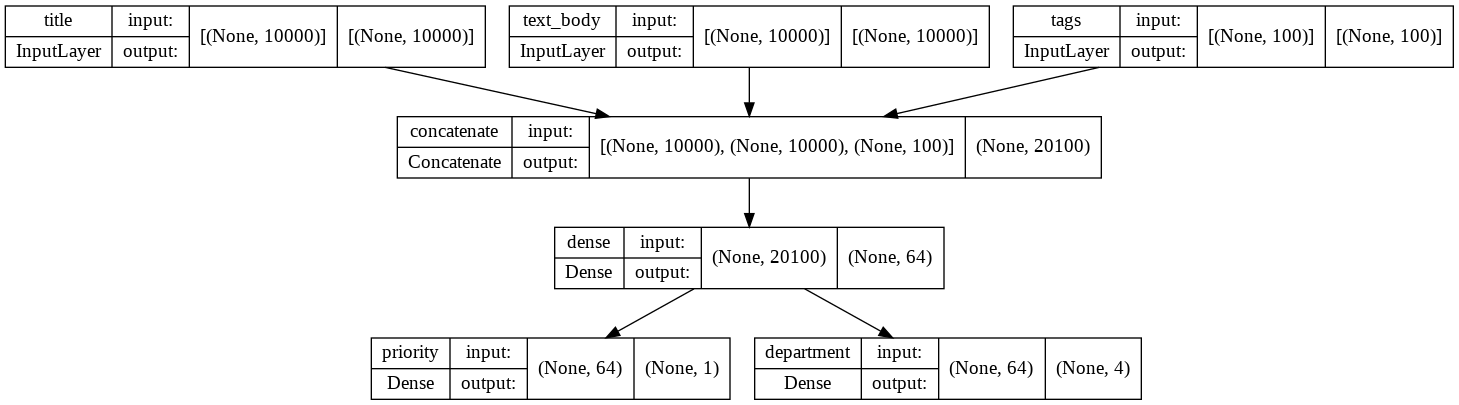

In [5]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

In [6]:
model.layers

In [7]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [8]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

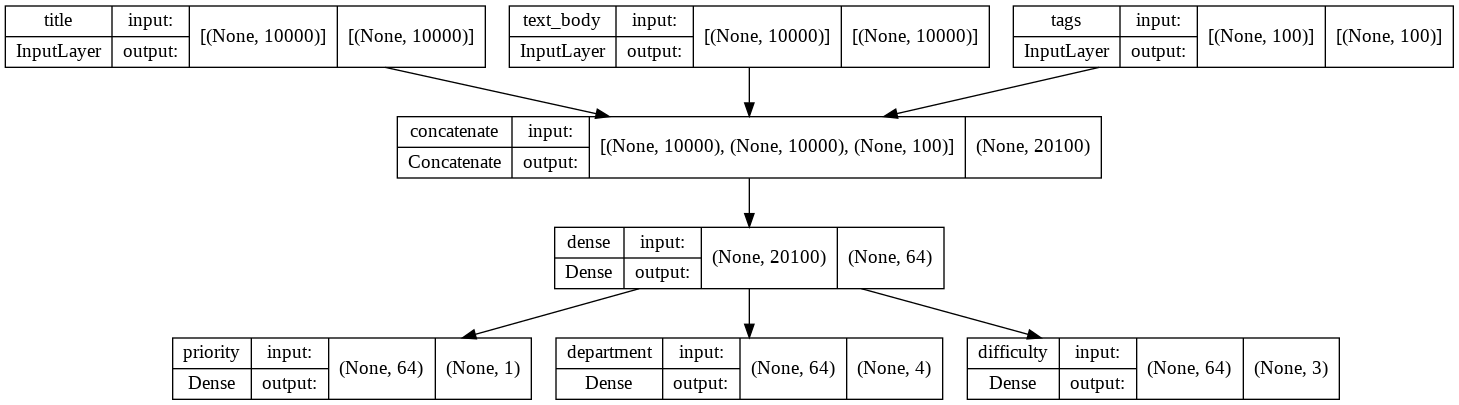

In [9]:
# Creating a new model by reusing intermediate layer outputs
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(inputs=[title, text_body, tags],
                        outputs=[priority, department, difficulty])

keras.utils.plot_model(new_model, "updated_ticket_classification.png", show_shapes=True)

In [12]:
# Rewrite the above model as a subclassed model
class CustomerTicketModel(keras.Model):

  def __init__(self, num_departments):
    super().__init__()
    self.concat_layer = layers.Concatenate()
    self.mixing_layer = layers.Dense(64, activation="relu")
    self.priority_scorer = layers.Dense(1, activation="sigmoid")
    self.department_classifier = layers.Dense(num_departments, activation="softmax")

  def call(self, inputs):
    title = inputs["title"]
    text_body = inputs["text_body"]
    tags = inputs["tags"]
    features = self.concat_layer([title, text_body, tags])
    features = self.mixing_layer(features)
    priority = self.priority_scorer(features)
    department = self.department_classifier(features)
    return priority, department

model = CustomerTicketModel(4)
priority, department = model({"title": title_data, "text_body": text_body_data,
                              "tags": tags_data})

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"],["accuracy"]])
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          [priority_data, department_data], epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          [priority_data, department_data])
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 1s 15ms/step - loss: 15.1254 - output_1_loss: 0.3368 - output_2_loss: 14.7886 - output_1_mean_absolute_error: 0.5001 - output_2_accuracy: 0.5773


In [14]:
# Using built-in training and evaluation loops
from tensorflow.keras.datasets import mnist

def get_mnist_model():
  inputs = keras.Input(shape=(28*28,))
  features = layers.Dense(512, activation="relu")(inputs)
  features = layers.Dropout(0.5)(features)
  outputs = layers.Dense(10, activation="softmax")(features)
  model = keras.Model(inputs, outputs)
  return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28*28)).astype("float32")/255
test_images = test_images.reshape((10000, 28*28)).astype("float32")/255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=3, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 17s 10ms/step - loss: 0.2953 - accuracy: 0.9113 - val_loss: 0.1432 - val_accuracy: 0.9598
Epoch 2/3
1563/1563 [==============================] - 13s 8ms/step - loss: 0.1637 - accuracy: 0.9539 - val_loss: 0.1178 - val_accuracy: 0.9677
Epoch 3/3
313/313 [==============================] - 1s 4ms/step - loss: 0.1054 - accuracy: 0.9718


In [15]:
# Implementing a custom metric by subclassing the Metric class
class RootMeanSquaredError(keras.metrics.Metric):
  def __init__(self, name="rmse", **kwargs):
    super().__init__(name=name, **kwargs)
    self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
    self.total_samples = self.add_weight(name="total_samples", initializer="zeros",dtype="int32")

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
    mse = tf.reduce_sum(tf.square(y_true - y_pred))
    self.mse_sum.assign_add(mse)
    num_samples = tf.shape(y_pred)[0]
    self.total_samples.assign_add(num_samples)

  def result(self):
    return tf.sqrt(self.mse_sum/tf.cast(self.total_samples, tf.float32))

  def reset_state(self):
    self.mse_sum.assign(0.)
    self.total_samples.assign(0)